<a href="https://colab.research.google.com/github/hansikyung/2023_openai_cookbook/blob/main/%EA%B0%95%EC%9D%98_6%EA%B8%B0_AI%EA%B0%9C%EB%A1%A0_13%EC%B0%A8%EC%8B%9C_02_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98%EA%B8%B0_%EC%B4%88%EA%B8%89%5Blive%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 나만의 이미지 분류기 만들기 (초급)

##  학습 목표
이 실습에서는 인공지능이 이미지를 어떻게 분류하는지 배웁니다!

**배울 내용:**
1. 사전 학습된 AI 모델 사용하기
2. 이미지 데이터 준비하기
3. 모델 학습시키기
4. 결과 확인하기


### 사전 학습 모델이란?

마치 이미 많은 그림을 본 화가처럼, 이 AI 모델은 이미 수백만 장의 이미지로 학습되어 있습니다.

우리는 이 똑똑한 모델을 가져와서 우리의 문제(CIFAR-10 이미지 분류)에 맞게 **약간만 조정**하면 됩니다!

---

In [17]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [18]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

런타임 다시 시작하세요

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

# matplotlib 기본 폰트로 지정
matplotlib.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료:", matplotlib.rcParams['font.family'])


한글 폰트 설정 완료: ['NanumGothic']


## 1단계: 필요한 도구 준비하기

요리를 시작하기 전에 재료와 도구를 준비하는 것처럼,
AI 모델을 만들기 전에 필요한 라이브러리를 불러옵니다.

In [2]:
# 필요한 라이브러리 가져오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision  # 이미지 처리 도구
import torchvision.transforms as transforms  # 이미지 변환 도구
import torchvision.models as models  # 사전 학습된 모델

import matplotlib.pyplot as plt
import numpy as np  # 숫자 계산
from tqdm import tqdm  # 진행 상태 표시

# 결과를 항상 같게 만들기 (재현성)
torch.manual_seed(42)

# GPU 사용 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('준비 완료!')
print(f'사용할 장치: {device}')
if device.type == 'cuda':
    print(f'GPU 이름: {torch.cuda.get_device_name(0)}')
    print('GPU로 빠르게 학습할 수 있어요!')
else:
    print('CPU로 학습합니다. 조금 느릴 수 있어요.')

준비 완료!
사용할 장치: cuda
GPU 이름: NVIDIA L4
GPU로 빠르게 학습할 수 있어요!


## 2단계: 이미지 데이터 준비하기

**CIFAR-10 데이터셋:**
- 10가지 종류의 물체 사진 (비행기, 자동차, 새, 고양이 등)
- 총 60,000장의 작은 이미지 (32x32 픽셀)
- 50,000장으로 학습, 10,000장으로 테스트

**이미지 변환:**
- 크기를 112x112로 키웁니다 (더 자세하게 볼 수 있도록)
- 좌우 반전으로 데이터를 늘립니다 (데이터 증강)
- 숫자로 변환하고 정규화합니다

In [3]:
# 이미지를 변환하는 방법 정의
# 훈련용 이미지 변환 (데이터를 늘리기 위한 증강 포함)
train_transform = transforms.Compose([
    # 코드 작성
    # 크기를 112x112로 조정
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(),
    # 50% 확률로 좌우 반전
    # 이미지를 숫자(텐서)로 변환
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # RGB 평균값으로 정규화
        std=[0.229, 0.224, 0.225]     # RGB 표준편차로 정규화
    )
])

# 테스트용 이미지 변환 (증강 없음)
test_transform = transforms.Compose([
    # 코드 작성
    # 크기를 112x112로 조정
    transforms.Resize(112),
    # 이미지를 숫자(텐서)로 변환
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# 훈련 데이터 다운로드 및 준비
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',  # 데이터를 저장할 폴더
    train=True,     # 훈련 데이터 사용
    download=True,  # 없으면 다운로드
    transform=train_transform  # 위에서 정의한 변환 적용
)

# 테스트 데이터 다운로드 및 준비
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,    # 테스트 데이터 사용
    download=True,
    transform=test_transform
)

# 데이터 로더 생성 (배치로 묶어서 제공)
train_loader  = DataLoader(
                train_dataset,
                batch_size = 64,
                shuffle = True,  # 데이터 섞기
                num_workers=2    # 병렬 처리
            )


test_loader  = DataLoader(
               test_dataset,
               batch_size = 64,
               shuffle = False,  # 데이터 섞지 않음
               num_workers=2    # 병렬 처리
            )

# 클래스 이름 (10가지 물체)
classes = ['비행기', '자동차', '새', '고양이', '사슴',
           '개', '개구리', '말', '배', '트럭']

print(f'   훈련 이미지: {len(train_dataset):,}장')
print(f'   테스트 이미지: {len(test_dataset):,}장')
print(f'   분류할 종류: {len(classes)}가지')
print(f'   배치 크기: {train_loader.batch_size}장씩')

   훈련 이미지: 50,000장
   테스트 이미지: 10,000장
   분류할 종류: 10가지
   배치 크기: 64장씩


## 2-1단계: 데이터 미리보기

어떤 이미지로 학습하는지 확인해봅시다!

샘플 이미지를 확인:


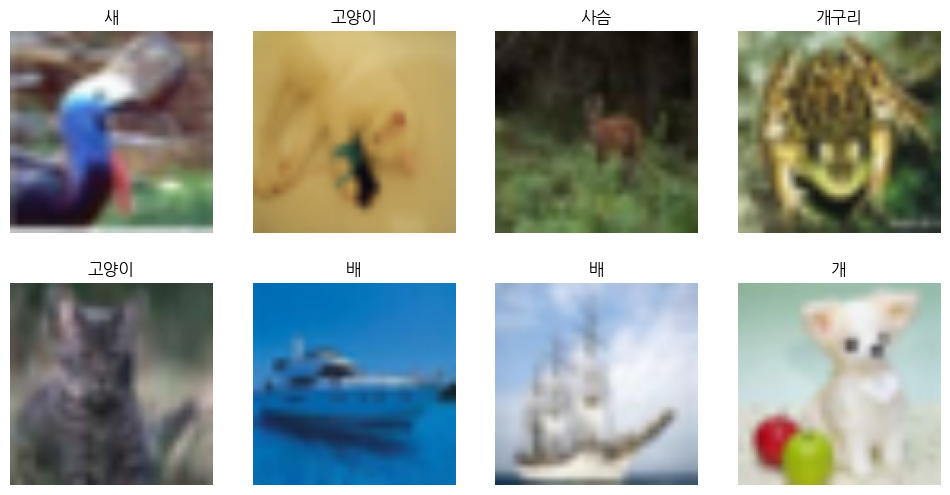

In [7]:
# 샘플 이미지 보기
def show_sample_images(loader, classes, num_images=8):
    """
    데이터에서 샘플 이미지를 보여주는 함수
    """
    # 데이터 가져오기
    images, labels = next(iter(loader))

    # 정규화 해제(다시 원래 이미지로) >> [0,1] 범위로 복원하는 과정
    # 정규화 : x_norm = (x - x_mean) / sigma(std)
    # 정규화 해제: x = x_norm * std + mean
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    # 채널별 평균(mean) 텐서 생성 : [3,1,1] (브로드캐스팅으로 각 픽셀에 채널별 평균을 적용하려고)
    std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    # 채널별 표준편차(std) 텐서 생성 : [3,1,1] (브로드캐스팅으로 각 픽셀에 채널별 표준편차를 적용하려고)
    images = images * std + mean

    # 값 범위 고정(clamp): 시각화/저장 전에 안전하게 [0,1] 구간으로 잘라냄
    # >> 픽셀(pixel) 범위 [0.1] 로 제한
    images = torch.clamp(images, 0, 1)

    # 그리드로 표시
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    # 배치 이미지 텐서를 2×4 격자(grid)로 시각화하는 예시
    axes = axes.ravel()
    # axes는 2×4 배열 형태이므로, 편하게 1차원으로 평탄화
    # print(axes)

    for i in range(num_images):
        # 이미지를 화면에 표시할 수 있는 형태로 변환
        img = images[i].permute(1, 2, 0).numpy()
        # permute(1, 2, 0) : (CHW→HWC) PyTorch 텐서 이미지는 보통 CHW.
        axes[i].imshow(img)
        axes[i].set_title(f'{classes[labels[i]]}', fontsize=12)
        axes[i].axis('off')


    plt.show()

print('샘플 이미지를 확인:')
show_sample_images(train_loader, classes)

## 3단계: AI 모델 만들기

**MobileNetV2 모델:**
- 이미 수백만 장의 이미지로 학습된 똑똑한 모델
- 가볍고 빠른 모델 (모바일에서도 사용 가능)
- 마지막 부분만 우리 문제에 맞게 바꿔요

**왜 사전 학습 모델을 사용할까?**
- 처음부터 학습하면 시간이 너무 오래 걸려요 (몇 주일!)
- 이미 학습된 모델은 이미지의 기본 특징을 알고 있어요
- 우리는 마지막 부분만 조정하면 돼요 (몇 분!)

In [5]:
# 사전 학습된 MobileNetV2 모델 불러오기
# 전이학습(Transfer Learning)
model = models.mobilenet_v2(weights='IMAGENET1K_V1')

# 모델의 마지막 부분 확인
print('\n원래 모델의 마지막 부분:')
print(f'  출력: {model.classifier[1].out_features}개 (ImageNet의 1000개 클래스)')
# model.classifier[1]은 그 중 마지막 선형 계층(Linear Layer) 을 의미
# out_features는 출력 노드의 개수, 즉 분류할 클래스 개수를 나타냄

# 마지막 레이어를 우리 문제에 맞게 교체
# CIFAR-10은 10개 클래스만 있으므로
num_features = model.classifier[1].in_features  # 입력 특징 개수
# MobileNetV2에서는 일반적으로 1280차원임
model.classifier[1] = nn.Linear(num_features, 10)  # 10개 클래스로 변경

print('\n수정된 모델의 마지막 부분:')
print(f'  출력: 10개 (CIFAR-10의 10개 클래스)')

# 모델을 GPU로 이동 (있으면)
model = model.to(device)

# 모델 파라미터 개수 확인
total_params = sum(p.numel() for p in model.parameters())
# p.numel() : 각 파라미터 텐서의 원소(숫자) 개수를 반환
print(f'\n모델 파라미터 개수: {total_params:,}개')
print('(약 230만 개의 숫자를 학습합니다!)')


원래 모델의 마지막 부분:
  출력: 1000개 (ImageNet의 1000개 클래스)

수정된 모델의 마지막 부분:
  출력: 10개 (CIFAR-10의 10개 클래스)

모델 파라미터 개수: 2,236,682개
(약 230만 개의 숫자를 학습합니다!)


## 4단계: 학습 설정하기

모델을 학습시키기 위해 필요한 것들:

1. **손실 함수 (Loss Function):**
   - 모델이 얼마나 틀렸는지 계산
   - 숫자가 작을수록 잘 맞춘 것!

2. **최적화 함수 (Optimizer):**
   - 모델을 어떻게 개선할지 결정
   - SGD (Stochastic Gradient Descent) 사용

3. **학습률 (Learning Rate):**
   - 한 번에 얼마나 많이 배울지 조절
   - 0.001 = 천천히 조심스럽게 학습

In [8]:
# 1. 손실 함수: 모델이 얼마나 틀렸는지 계산
criterion = nn.CrossEntropyLoss()

# 2. 최적화 함수: 모델을 어떻게 개선할지
# 코드 작성
optimizer = optim.SGD(
            model.parameters(), # 학습할 파라미터(학습 대상)
            lr = 0.001,         # 학습률
            momentum=0.9        # 관성 반영(더 안정적으로 학습)
        )
# 학습 설정
num_epochs = 30  # 전체 데이터를 30번 반복해서 학습

print('학습 설정 완료!')
print(f'  손실 함수: {criterion.__class__.__name__}')
print(f'  최적화 함수: {optimizer.__class__.__name__}')
print(f'  학습률: {optimizer.param_groups[0]["lr"]}')
# optimizer.param_groups[0] → 첫 번째 파라미터 그룹의 학습률(learning rate) 값
print(f'  학습 횟수: {num_epochs}번')

학습 설정 완료!
  손실 함수: CrossEntropyLoss
  최적화 함수: SGD
  학습률: 0.001
  학습 횟수: 30번


## 5단계: 모델 학습시키기

드디어 모델을 학습시킬 시간입니다!

**학습 과정:**
1. 이미지를 모델에 입력
2. 모델이 예측
3. 정답과 비교해서 오차 계산
4. 오차를 줄이는 방향으로 모델 조정
5. 반복!

**진행 상태:**
- `loss`: 손실 (작을수록 좋음)
- `acc`: 정확도 (클수록 좋음, 100%가 완벽)

In [9]:
# 학습 기록을 저장할 리스트
train_losses = []  # 훈련 손실
train_accs = []    # 훈련 정확도
test_accs = []     # 테스트 정확도

print('학습 시작!')
print('=' * 60)


# 에폭마다 반복
for epoch in range(num_epochs):
    print(f'\n에폭 {epoch+1}/{num_epochs}')

    # ===== 훈련 단계 =====

    # 코드 작성
    model.train()

    running_loss = 0.0 # 손실 누적
    correct = 0        # 맞춘 개수
    total = 0          # 전체 개수

    for images, labels in tqdm(train_loader, desc="훈련"):
      images = images.to(device)
      labels = labels.to(device)

      # 1. 기울기 초기화
      optimizer.zero_grad()
      # 2. 순전파 : 모델이 예측
      outputs = model(images)
      # 3. 손실 계산
      loss = criterion(outputs, labels)
      # 4. 역전파 : 기울기 계산
      loss.backward()
      # 5. 가중치 업데이트
      optimizer.step()

      # 6. 통계계산
      running_loss += loss.item() * images.size(0)
      # loss.item() : 현재 배치 평균 손실 값을 파이썬 숫자로 꺼냄
      # images.size(0) : 배치 크기
      _, predicted = torch.max(outputs, 1)
      # torch.max(outputs, 1) 각 샘플에 대해 가장 큰 로짓값(모델이 예측한 값)과 그 인덱스(예측 클래스) 반환
      total  += labels.size(0)
      correct += (predicted == labels).sum().item()

    # epoch 단위 평균 손실/정확도 계산
    # 에폭 평균 계산
    # running loss >> 배치 손실 + 배치 크기 합 >> total (전체 샘플 수)로 나눠 에폭 평균 손실

    epoch_loss  = running_loss / total
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ===== 테스트 단계 =====
    model.eval()  # 모델을 평가 모드로(Dropout 비활성, BatchNorm 고정)
    correct = 0
    total = 0

    # 코드 작성
    with torch.no_grad():   # 기울기 계산 안 함 (평가만)
      for images, labels in tqdm(test_loader, desc="테스트"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_accs.append(test_acc)

    # 결과 출력
    print(f'\n에폭 {epoch+1} 결과:')
    print(f'  훈련 손실: {epoch_loss:.4f}')
    print(f'  훈련 정확도: {epoch_acc:.2f}%')
    print(f'  테스트 정확도: {test_acc:.2f}%')
    print('-' * 60)

print('\n학습 완료!')
print('=' * 60)
print(f'최종 테스트 정확도: {test_accs[-1]:.2f}%')
print('=' * 60)

학습 시작!

에폭 1/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.79it/s]



에폭 1 결과:
  훈련 손실: 0.4541
  훈련 정확도: 84.73%
  테스트 정확도: 90.88%
------------------------------------------------------------

에폭 2/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.53it/s]



에폭 2 결과:
  훈련 손실: 0.2151
  훈련 정확도: 92.36%
  테스트 정확도: 92.35%
------------------------------------------------------------

에폭 3/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.09it/s]



에폭 3 결과:
  훈련 손실: 0.1558
  훈련 정확도: 94.73%
  테스트 정확도: 93.09%
------------------------------------------------------------

에폭 4/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.79it/s]



에폭 4 결과:
  훈련 손실: 0.1185
  훈련 정확도: 95.98%
  테스트 정확도: 93.52%
------------------------------------------------------------

에폭 5/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.20it/s]



에폭 5 결과:
  훈련 손실: 0.0940
  훈련 정확도: 96.80%
  테스트 정확도: 93.77%
------------------------------------------------------------

에폭 6/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.11it/s]



에폭 6 결과:
  훈련 손실: 0.0735
  훈련 정확도: 97.51%
  테스트 정확도: 93.78%
------------------------------------------------------------

에폭 7/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.99it/s]



에폭 7 결과:
  훈련 손실: 0.0574
  훈련 정확도: 98.07%
  테스트 정확도: 94.21%
------------------------------------------------------------

에폭 8/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.15it/s]



에폭 8 결과:
  훈련 손실: 0.0443
  훈련 정확도: 98.52%
  테스트 정확도: 94.27%
------------------------------------------------------------

에폭 9/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.54it/s]



에폭 9 결과:
  훈련 손실: 0.0414
  훈련 정확도: 98.63%
  테스트 정확도: 94.18%
------------------------------------------------------------

에폭 10/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.43it/s]



에폭 10 결과:
  훈련 손실: 0.0316
  훈련 정확도: 98.98%
  테스트 정확도: 94.27%
------------------------------------------------------------

에폭 11/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.23it/s]



에폭 11 결과:
  훈련 손실: 0.0293
  훈련 정확도: 99.10%
  테스트 정확도: 94.02%
------------------------------------------------------------

에폭 12/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.28it/s]



에폭 12 결과:
  훈련 손실: 0.0244
  훈련 정확도: 99.21%
  테스트 정확도: 94.13%
------------------------------------------------------------

에폭 13/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.09it/s]



에폭 13 결과:
  훈련 손실: 0.0206
  훈련 정확도: 99.34%
  테스트 정확도: 94.00%
------------------------------------------------------------

에폭 14/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.45it/s]



에폭 14 결과:
  훈련 손실: 0.0182
  훈련 정확도: 99.43%
  테스트 정확도: 94.49%
------------------------------------------------------------

에폭 15/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.98it/s]



에폭 15 결과:
  훈련 손실: 0.0158
  훈련 정확도: 99.50%
  테스트 정확도: 94.53%
------------------------------------------------------------

에폭 16/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.62it/s]



에폭 16 결과:
  훈련 손실: 0.0148
  훈련 정확도: 99.53%
  테스트 정확도: 94.25%
------------------------------------------------------------

에폭 17/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.48it/s]



에폭 17 결과:
  훈련 손실: 0.0121
  훈련 정확도: 99.65%
  테스트 정확도: 94.39%
------------------------------------------------------------

에폭 18/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.19it/s]



에폭 18 결과:
  훈련 손실: 0.0115
  훈련 정확도: 99.67%
  테스트 정확도: 94.00%
------------------------------------------------------------

에폭 19/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.15it/s]



에폭 19 결과:
  훈련 손실: 0.0093
  훈련 정확도: 99.75%
  테스트 정확도: 94.63%
------------------------------------------------------------

에폭 20/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.03it/s]



에폭 20 결과:
  훈련 손실: 0.0091
  훈련 정확도: 99.72%
  테스트 정확도: 94.39%
------------------------------------------------------------

에폭 21/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.02it/s]



에폭 21 결과:
  훈련 손실: 0.0089
  훈련 정확도: 99.74%
  테스트 정확도: 94.47%
------------------------------------------------------------

에폭 22/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.73it/s]



에폭 22 결과:
  훈련 손실: 0.0100
  훈련 정확도: 99.68%
  테스트 정확도: 94.48%
------------------------------------------------------------

에폭 23/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.98it/s]



에폭 23 결과:
  훈련 손실: 0.0094
  훈련 정확도: 99.73%
  테스트 정확도: 94.49%
------------------------------------------------------------

에폭 24/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 43.19it/s]



에폭 24 결과:
  훈련 손실: 0.0063
  훈련 정확도: 99.83%
  테스트 정확도: 94.69%
------------------------------------------------------------

에폭 25/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.30it/s]



에폭 25 결과:
  훈련 손실: 0.0065
  훈련 정확도: 99.81%
  테스트 정확도: 94.73%
------------------------------------------------------------

에폭 26/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s]



에폭 26 결과:
  훈련 손실: 0.0068
  훈련 정확도: 99.81%
  테스트 정확도: 94.34%
------------------------------------------------------------

에폭 27/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 42.42it/s]



에폭 27 결과:
  훈련 손실: 0.0061
  훈련 정확도: 99.83%
  테스트 정확도: 94.24%
------------------------------------------------------------

에폭 28/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.10it/s]



에폭 28 결과:
  훈련 손실: 0.0070
  훈련 정확도: 99.78%
  테스트 정확도: 94.58%
------------------------------------------------------------

에폭 29/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 45.04it/s]



에폭 29 결과:
  훈련 손실: 0.0059
  훈련 정확도: 99.82%
  테스트 정확도: 94.64%
------------------------------------------------------------

에폭 30/30


테스트: 100%|██████████| 157/157 [00:03<00:00, 44.25it/s]


에폭 30 결과:
  훈련 손실: 0.0076
  훈련 정확도: 99.77%
  테스트 정확도: 94.52%
------------------------------------------------------------

학습 완료!
최종 테스트 정확도: 94.52%


##  6단계: 학습 결과 확인하기

학습이 잘 되었는지 그래프로 확인해봅시다!

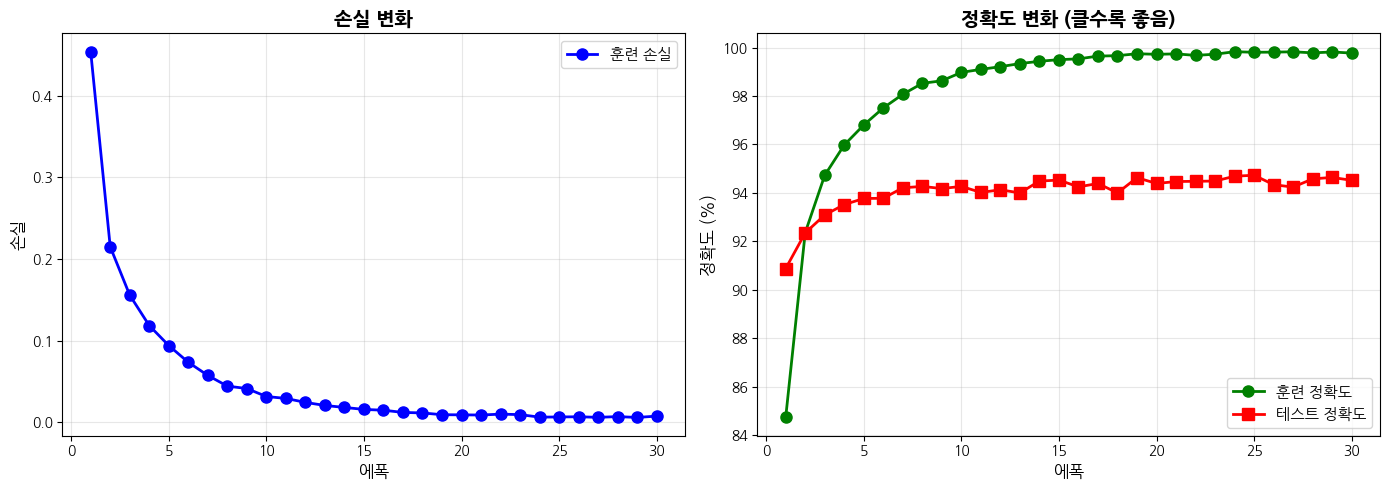


학습 결과 요약
시작 정확도: 90.88%
최종 정확도: 94.52%
향상도: +3.64%p
훌륭해요! 85% 이상의 정확도를 달성했습니다!


In [10]:
# 학습 곡선 그리기
def plot_results(train_losses, train_accs, test_accs):
    """
    학습 결과를 그래프로 그리는 함수
    """
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 손실 그래프
    axes[0].plot(epochs, train_losses, 'b-o', linewidth=2, markersize=8, label='훈련 손실')
    axes[0].set_xlabel('에폭', fontsize=12)
    axes[0].set_ylabel('손실', fontsize=12)
    axes[0].set_title('손실 변화', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # 정확도 그래프
    axes[1].plot(epochs, train_accs, 'g-o', linewidth=2, markersize=8, label='훈련 정확도')
    axes[1].plot(epochs, test_accs, 'r-s', linewidth=2, markersize=8, label='테스트 정확도')
    axes[1].set_xlabel('에폭', fontsize=12)
    axes[1].set_ylabel('정확도 (%)', fontsize=12)
    axes[1].set_title('정확도 변화 (클수록 좋음)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 결과 요약
    print('\n학습 결과 요약')
    print('=' * 60)
    print(f'시작 정확도: {test_accs[0]:.2f}%')
    print(f'최종 정확도: {test_accs[-1]:.2f}%')
    print(f'향상도: {test_accs[-1] - test_accs[0]:+.2f}%p')
    print('=' * 60)

    # 해석
    if test_accs[-1] >= 85:
        print('훌륭해요! 85% 이상의 정확도를 달성했습니다!')
    elif test_accs[-1] >= 75:
        print('좋아요! 75% 이상의 정확도를 달성했습니다!')
    else:
        print('괜찮아요! 더 많은 에폭으로 학습하면 더 좋아질 거예요!')

# 그래프 그리기
plot_results(train_losses, train_accs, test_accs)

##  7단계: 실제 예측 확인하기

우리 모델이 실제로 이미지를 어떻게 분류하는지 확인해봅시다!

'Permute'는 영어 동사로, 어떤 항목들(원소, 요소, 차원 등)의 순서나 위치를 서로 교환하여 새로운 배열을 만드는 행위를 의미합니다.

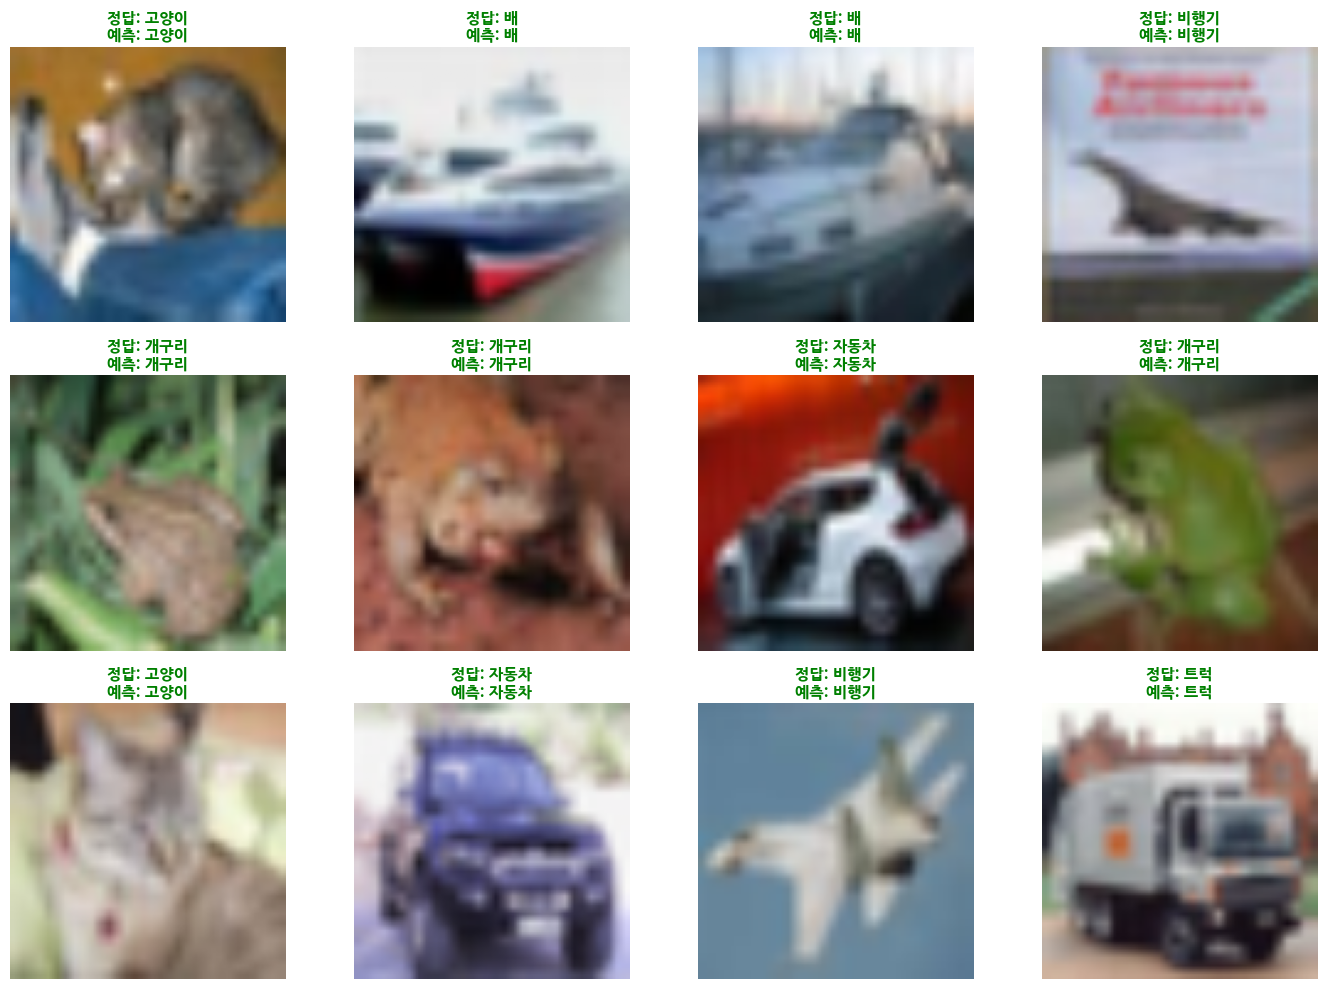


이 샘플에서 12개 중 12개를 맞췄어요!
정확도: 100.0%


In [11]:
# 예측 결과 시각화
def show_predictions(model, loader, classes, device, num_images=12):
    """
    모델의 예측 결과를 시각화하는 함수
    """
    model.eval()

    # 데이터 가져오기
    images, labels = next(iter(loader))
    images = images.to(device)

    # 예측
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # CPU로 이동
    images = images.cpu()
    predicted = predicted.cpu()

    # 정규화 해제
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # 시각화
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.ravel()

    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)

        # 정답과 예측 비교
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]

        # 맞으면 초록색, 틀리면 빨간색
        if labels[i] == predicted[i]:
            color = 'green'

        else:
            color = 'red'

        axes[i].set_title(
            f'정답: {true_label}\n예측: {pred_label}',
            color=color,
            fontsize=11,
            fontweight='bold'
        )
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # 정확도 계산
    correct = (predicted[:num_images] == labels[:num_images]).sum().item()
    accuracy = 100 * correct / num_images

    print(f'\n이 샘플에서 {num_images}개 중 {correct}개를 맞췄어요!')
    print(f'정확도: {accuracy:.1f}%')

show_predictions(model, test_loader, classes, device, num_images=12)

## 8단계: 클래스별 성능 확인

어떤 물체를 잘 맞추고, 어떤 물체를 어려워하는지 확인해봅시다!

In [12]:
cls = ["사람", "고양이","개"]
[0] * len(cls)

[0, 0, 0]

In [15]:
# 클래스별 정확도 계산
def evaluate_per_class(model, loader, classes, device):
    """
    클래스별 성능을 평가하는 함수
    """
    model.eval()

    # 클래스별 맞춘 개수와 전체 개수
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='클래스별 평가'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # 클래스별로 집계
            c = (predicted == labels)
            for i in range(len(labels)):
               label = labels[i]
               class_correct[label] += c[i].item()
               class_total[label] += 1

            # 코드 작성

    # 결과 출력
    print('\n클래스별 정확도')
    print('=' * 50)

    accuracies = []

    # 코드 작성
    for i, class_name in enumerate(classes):
        if class_total[i] > 0 :
          acc =100 * class_correct[i] / class_total[i]
          accuracies.append(acc)

          print(f'{class_name:8s} {acc:5.1f}%')

    print('=' * 50)
    print(f'평균 정확도: {np.mean(accuracies):.2f}%')

    # 가장 잘 맞추는 것과 어려워하는 것

    # 코드 작성
    best_idx = np.argmax(accuracies)
    worst_idx = np.argmin(accuracies)

    print(f'\n가장 잘 맞추는 것: {classes[best_idx]} ({accuracies[best_idx]:.1f}%)')
    print(f'가장 어려워하는 것: {classes[worst_idx]} ({accuracies[worst_idx]:.1f}%)')

# 클래스별 평가
evaluate_per_class(model, test_loader, classes, device)

클래스별 평가: 100%|██████████| 157/157 [00:03<00:00, 43.82it/s]


클래스별 정확도
비행기       96.2%
자동차       97.9%
새         94.3%
고양이       87.0%
사슴        95.4%
개         89.1%
개구리       96.9%
말         96.8%
배         95.5%
트럭        96.1%
평균 정확도: 94.52%

가장 잘 맞추는 것: 자동차 (97.9%)
가장 어려워하는 것: 고양이 (87.0%)


## 9단계: 모델 저장하기 (선택사항)

학습한 모델을 저장하면 나중에 다시 사용할 수 있어요!

In [14]:
# 모델 저장
model_path = "my_image_classifer.pth"
torch.save(model.state_dict(), model_path)
# 코드 작성

print(f'모델 저장 완료: {model_path}')
print('\n나중에 이 모델을 불러오려면:')
print('```python')
print('model = models.mobilenet_v2()')
print('model.classifier[1] = nn.Linear(1280, 10)')
print(f'model.load_state_dict(torch.load("{model_path}"))')
print('model.eval()')
print('```')

모델 저장 완료: my_image_classifer.pth

나중에 이 모델을 불러오려면:
```python
model = models.mobilenet_v2()
model.classifier[1] = nn.Linear(1280, 10)
model.load_state_dict(torch.load("my_image_classifer.pth"))
model.eval()
```


## 10단계: 학습 정리 및 복습

---


### 오늘 배운 내용

1. **사전 학습 모델 사용하기**
   - 이미 똑똑한 MobileNetV2 모델을 가져왔어요
   - 마지막 부분만 우리 문제에 맞게 바꿨어요

2. **이미지 데이터 준비하기**
   - CIFAR-10 데이터셋 사용 (10가지 물체)
   - 이미지 크기 조정, 좌우 반전 등 데이터 증강
   - 배치로 묶어서 효율적으로 처리

3. **모델 학습시키기**
   - 순전파: 모델이 예측
   - 손실 계산: 얼마나 틀렸는지
   - 역전파: 어떻게 고칠지
   - 가중치 업데이트: 실제로 고치기

4. **결과 확인하기**
   - 학습 곡선으로 진행 상황 확인
   - 예측 결과를 눈으로 확인
   - 클래스별 성능 분석

---

### 핵심 개념 정리

| 개념 | 설명 | 비유 |
|------|------|------|
| **사전 학습 모델** | 이미 학습된 모델 | 경험 많은 선생님  |
| **파인 튜닝** | 마지막 부분만 조정 | 새로운 과목만 공부하기 |
| **손실 함수** | 틀린 정도 측정 | 시험 점수  |
| **최적화 함수** | 개선 방법 | 공부 방법 |
| **에폭** | 전체 데이터 1회 학습 | 교과서 1번 읽기  |

---

### 더 나아가기

**이 모델을 더 좋게 만들려면?**

1. **더 많이 학습하기**
   - `num_epochs`를 10이나 20으로 늘려보세요
   - 정확도가 더 올라갈 거예요!

2. **더 강력한 데이터 증강**
   - 회전, 색상 변경, 자르기 등 추가
   - 모델이 더 다양한 상황에 대응할 수 있어요

3. **다른 모델 시도하기**
   - ResNet-18, ResNet-50, EfficientNet 등
   - 더 복잡한 모델은 더 정확할 수 있어요

4. **학습률 조정하기**
   - 학습률 스케줄러 사용
   - 학습 초반은 빠르게, 후반은 천천히



In [16]:
# eos